# HSKA AI-Lab RL: Q-Learning

## Mount Google Drive as folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My\ Drive/ai-lab/rl

## Temporal-Difference Methoden

In diesem Notebook geht es darum Q-Learning anhand des Beispiels [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) zu implementieren. CliffWalking steht im OpenAI Gym zur Verfügung und wird in der Implementierung (`CliffWalkingEnv`) wie folgt beschrieben:

```python
"""
This is a simple implementation of the Gridworld Cliff
reinforcement learning task.
Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
by Sutton and Barto:
http://incompleteideas.net/book/bookdraft2018jan1.pdf
With inspiration from:
https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py
The board is a 4x12 matrix, with (using Numpy matrix indexing):
    [3, 0] as the start at bottom-left
    [3, 11] as the goal at bottom-right
    [3, 1..10] as the cliff at bottom-center
Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
and a reset to the start. An episode terminates when the agent reaches the goal.
"""
```

### CliffWalking Environment kennenlernen

In [1]:
%pip install --upgrade pip
%pip install gym[atari]==0.12.5

import sys
import gym
import numpy as np
from collections import defaultdict
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

from plot_utils import plot_values
import check_test

Note: you may need to restart the kernel to use updated packages.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gym: filename=gym-0.12.5-py3-none-any.whl size=1613802 sha256=7f372dab6c2f9cd5793442a88a54cc232856a73fc9fa0b9423c44bbac071f158
  Stored in directory: c:\users\mbcub\appdata\local\pip\cache\wheels\05\65\a3\1f1e99de6963e1b6ecc748bdddba8dcb594d6554bbdcfe241f
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
env = gym.make('CliffWalking-v0')

Der Agent bewegt sich durch eine GridWorld mit den Maßen $4\times 12$, wobei die States wie folgt nummeriert sind:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
Zu Beginn jeder Episode startet der Agent in dem initialen State `36`. Der State `47` ist der einzige Terminal State. Die "Klippen" gehören zu den States `37` bis `46`. Sowohl State- als auch Action-Space sind diskret.

Der Agent hat 4 mögliche Actions zur Auswahl:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Mit $\mathcal{S}^+=\{0, 1, \ldots, 47\}$ und $\mathcal{A} =\{0, 1, 2, 3\}$ (siehe `action_space` und `observation_space` in der nachfolgenden Zelle). Führt der Agent eine Action aus, welche nicht durchführbar ist (z.B. Action `LEFT` in State `36`), bleibt der Agent in dem vorherigen State und erhält den entsprechenden Reward.

Die Reward Funktion ist unten abgebildet. Für jeden "Schritt" den der Agent macht, außer dem Wechsel in den Terminal State, wird dieser mit einem negativen Reward von `-1` bestraft. Kommt der Agent in einen `Cliff`-State, wird er mit einem Reward von `-100` bestraft.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


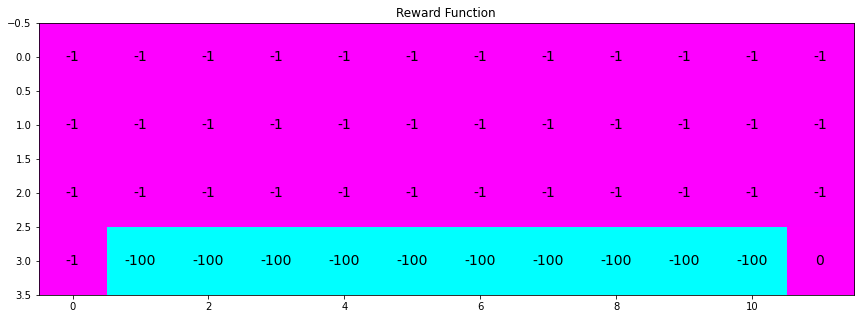

In [4]:
# Reward function
gridworld = np.full((4,12), -1)
gridworld[-1][1:-1] = -100
gridworld[-1][-1] = 0

plot_values(gridworld, title='Reward Function')

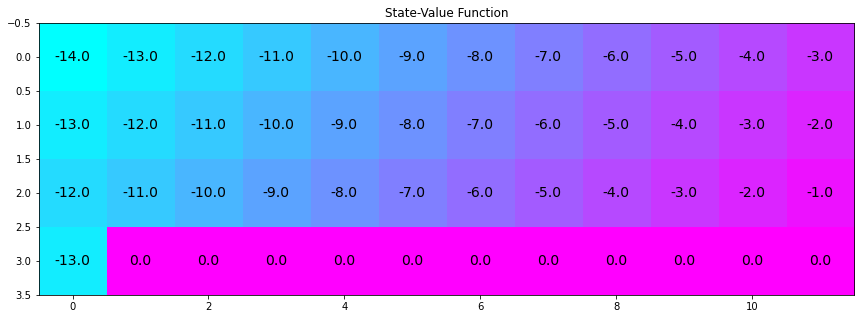

In [5]:
# Optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Aufgabe 1: TD Control: Q-Learning

In dieser Aufgabe soll Q-Learning implementiert werden, um im CliffWalking Environment die Q-Funktion lernen zu können. Dazu müssen folgende drei Methoden implementiert werden:

- `act`: Implementiert $\epsilon$-greedy Exploration-Strategy
- `train`: Lernen der Q-Funktion anhand der gesammelten Erfahrungen
- `q_learning`: Main-Loop des Q-Learning Algorithmus

In [20]:
def act(Q_state, action_size, eps):
    """Selects the action to be executed based on the given state.

    Implements epsilon greedy exploration strategy, i.e. with a probability of
    epsilon, a random action is selected.

    Args:
        state [int]: Number of current agent state.
        action_size [int]: Size of action space
        eps [float]: Hyperparameter epsilon for epsilon-greedy strategy.

    Returns:
        action [int]
    """
    if np.random.uniform() < eps:
        return np.random.randint(0, action_size - 1)
    return np.argmax(Q_state)

In [16]:
# Assertions, please do not change
np.random.seed(42)
assert act(np.array([1, 2, 3, 4]), 10, 1) == 7, 'Agent should explore the environment. Please check act method'
assert act(np.array([1, 2, 3, 4]), 10, 0) == 3, 'Agent should exploit the knowledge about the environment. Please check act method'

In [22]:
def train(curr_Q_value, next_Q_value, reward, alpha, gamma):
    """Learns the Q-values based on experience.

    Args:
        curr_Q_value [float]: Q-value of current state.
        next_Q_value [float]: Q-value of next state.
        reward [int]: Reward received from environment.
        alpha [float]: Hyperparameter alpha as step-size.
        gamma [float]: Hyperparameter gamma as discount factor.

    Returns:
        updated Q value [float]
    """
    #Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) — Q[state, action])
    return curr_Q_value + alpha * (reward + gamma * next_Q_value - curr_Q_value)

In [18]:
# Assertions, please do not change
assert train(-2.44, -1.23, 2.5, 0.77, 0.45) == 0.937605, 'Agent should learn the correct Q-value using Q-learning algorithm. Please check train method'

In [50]:
from tqdm import tqdm
def q_learning(env, num_episodes, alpha, gamma=1.0):
    """Main-loop of Q-learning algorithm.
    
    Args:
        env [gym.Env]: OpenAI Gym environment.
        num_episodes [int]: Number of episodes to train in environment.
        alpha [float]: Hyperparameter alpha as step-size.
        
    Returns:
        Q [dict]
    """
    Q = {key: np.zeros(env.action_space.n) for key in range(env.observation_space.n)}
    for _ in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        while not done:
            action = act(Q[state], env.action_space.n, 0.1)
            next_state, reward, done, _ = env.step(action)

            best_next_action = np.argmax(Q[next_state])
            Q[state][action] = train(Q[state][action], Q[next_state][best_next_action], reward, alpha, gamma)

            state = next_state
    return Q

100%|██████████| 5000/5000 [00:02<00:00, 1905.18it/s]


**TEST RESULT: <span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[0 1 0 2 1 1 1 1 0 2 2 2]
 [2 0 1 0 1 2 1 2 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


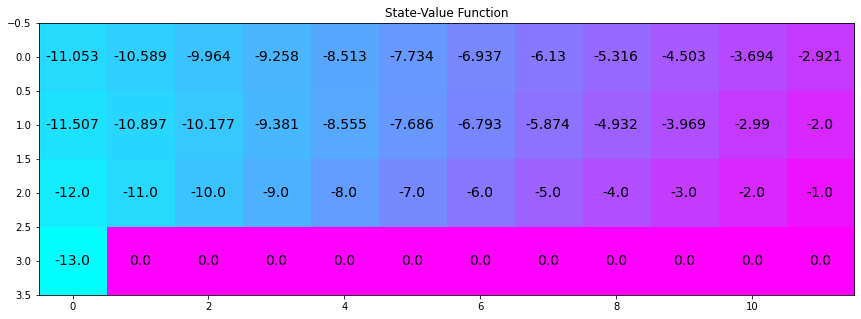

In [51]:
# Obtain the estimated optimal policy and corresponding action-value function
Q_learning = q_learning(env, num_episodes=5000, alpha=0.01)

# Print the estimated optimal policy
policy_Q_learning = np.array([np.argmax(Q_learning[key]) if key in Q_learning else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_Q_learning)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_Q_learning)

# Plot the estimated optimal state-value function
V_Q_learning = ([np.max(Q_learning[key]) if key in Q_learning else 0 for key in np.arange(48)])
plot_values(V_Q_learning)

### Quiz: Temporal-Difference Methoden

#### Frage 1: Wie lauten die Werte der Q-Tabelle in folgendem Szenario?

##### Setup

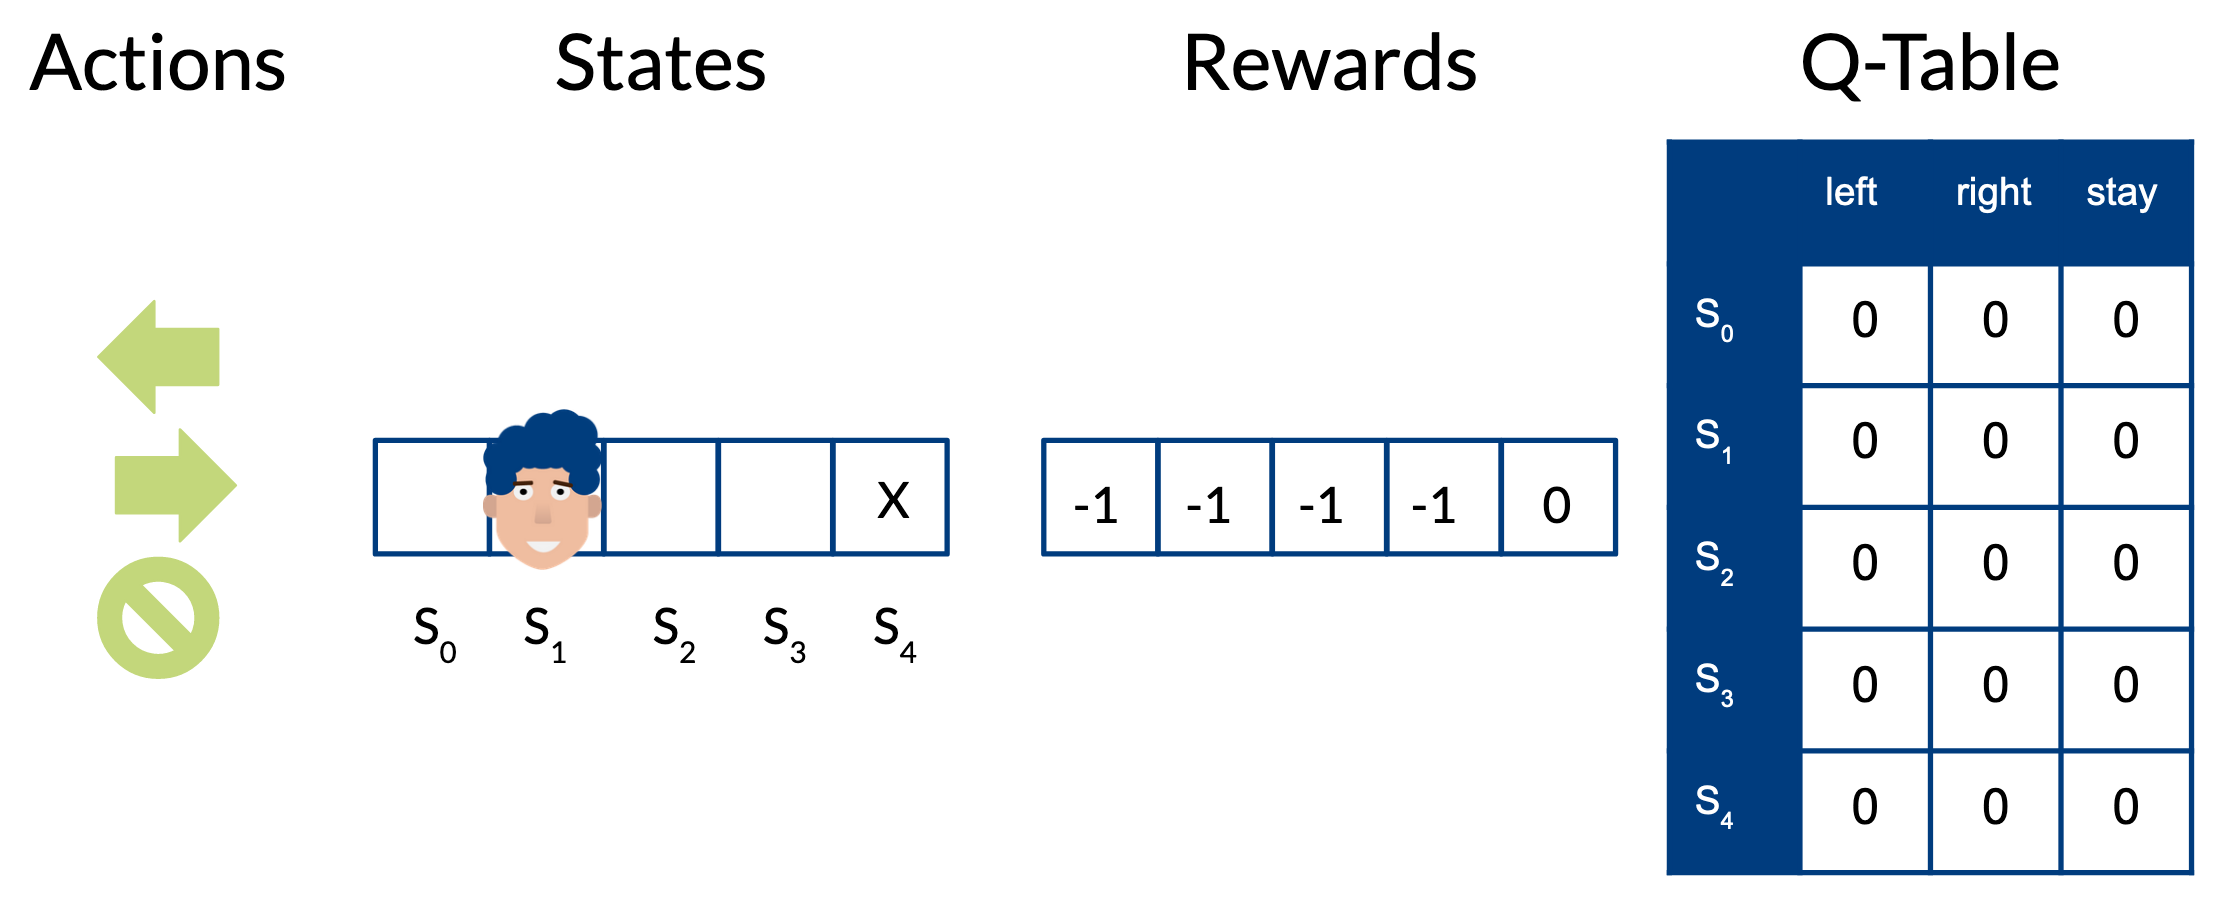

In [52]:
Image('./assets/session_1_task_1_0.png', width="600")

Mit $\alpha$ = 0.2 und $gamma$ = 1.0. Der Agent befindet sich in State $S_1$ zum Zeitpunkt $0$ (initialer State).

##### Episode 0, Time 0

Im initialen State $S_1$ entscheidet sich der Agent für Action "stay". Der entsprechende nachfolgende State ist weiterhin $S_1$. Vom Environment erhält der Agent einen Reward von $-1$. Wie sieht die Q-Tabelle aus bei Episode 0, Time 1?

Antwort (runde auf eine Stelle nach dem Komma):
$Q(S_1, stay) = Q(S_1, stay) + \alpha * (R_1 + \gamma * Q(S_1, stay) - Q(S_1, stay))$
$Q(S_1, stay) = 0 + 0.2 * (-1 + 1 * 0 - 0) = -0.2$

##### Episode n, TIme 0

Eine neue Episode beginnt und der Agent befindet sich wieder in State $S_1$ und entscheidet sich für die Action "stay". Was ist der neue Q-Wert für $Q(S_1, stay)$?

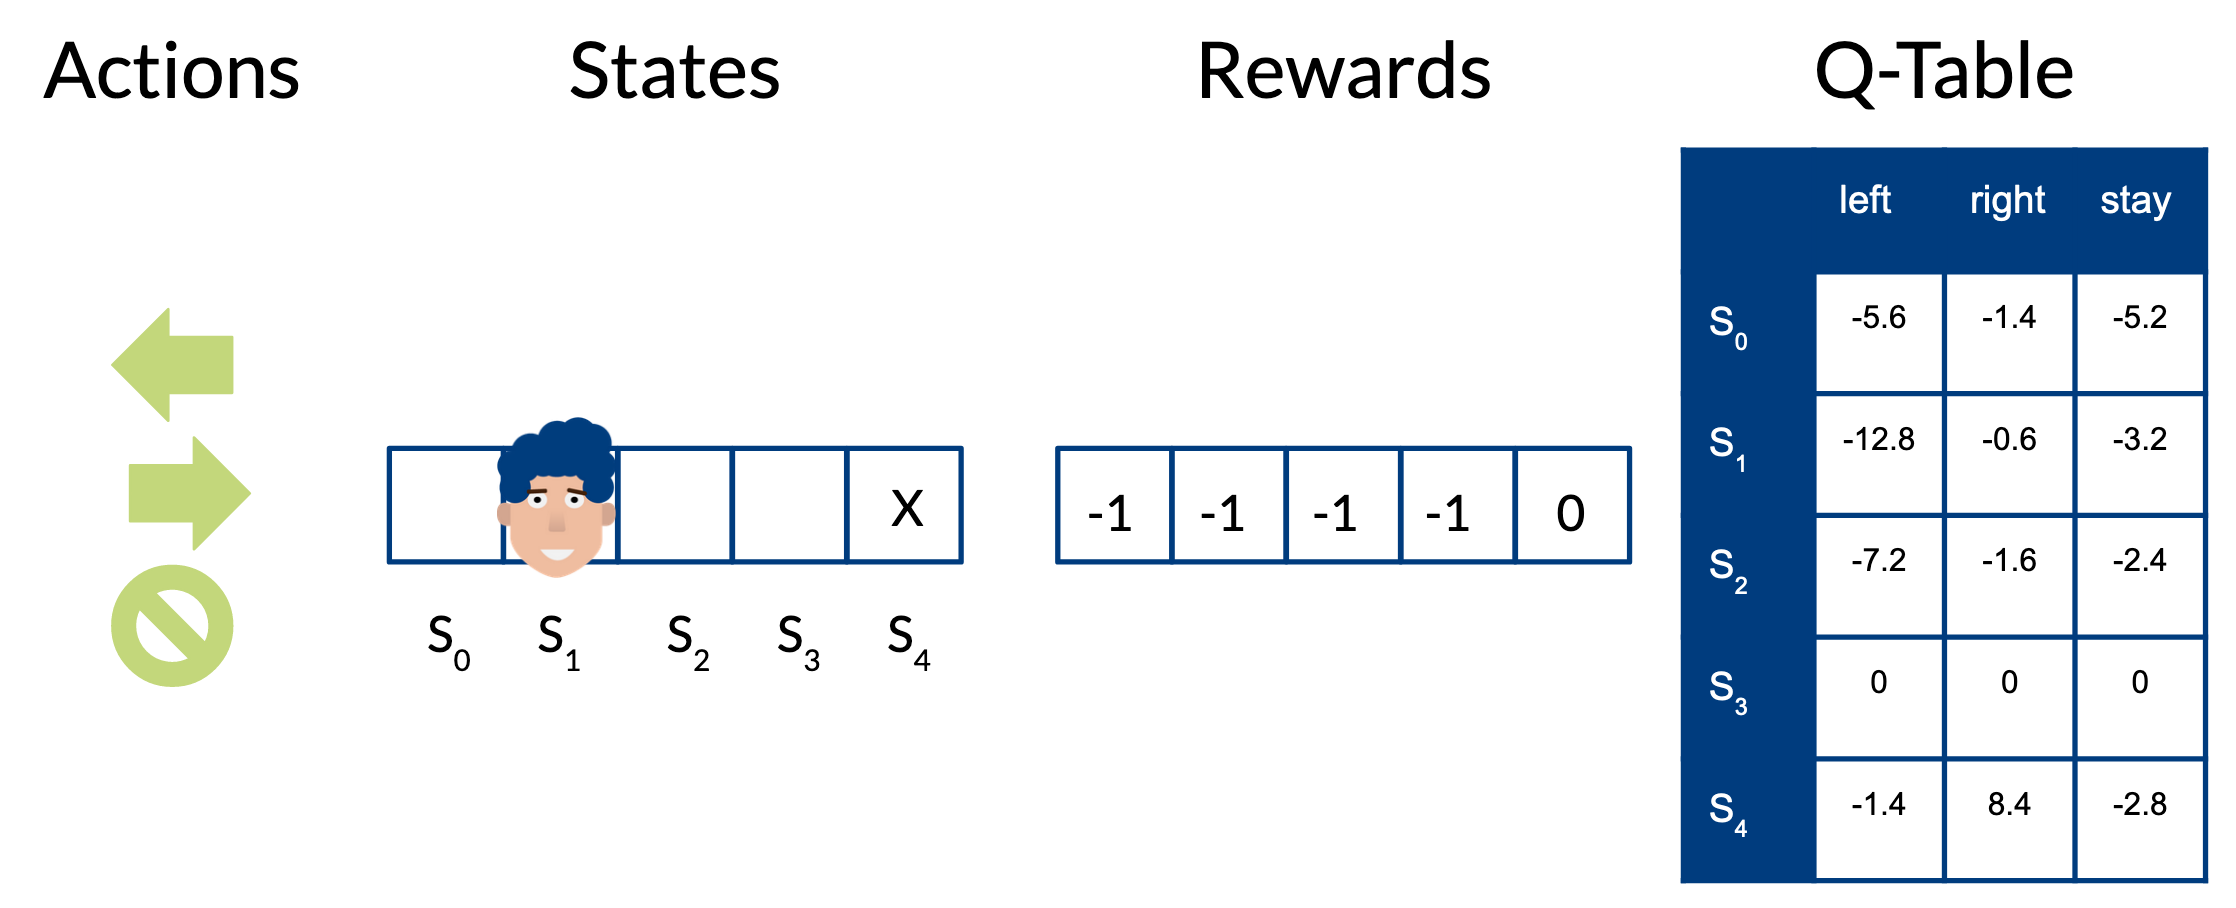

In [53]:
Image('./assets/session_1_task_1_1.png', width="600")

Antwort (runde auf eine Stelle nach dem Komma):
$Q(S_1, stay) = Q(S_1, stay) + \alpha * (R_1 + \gamma * Q(S_1, right) - Q(S_1, stay))$
$Q(S_1, stay) = -3.2 + 0.2 * (-1 + 1 * -0.6 - -3.2)) = -2.9

#### Frage 2: Was versteht man unter einer Optimal Policy?

Eine policy, die für jeden State S eine Aktion A liefert, welche den maximalen Reward R für die restliche Episode erzielt.